In [24]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

# COVID Dashboard

Analysis of current COVID 19 new case data from multiple sources

Analysis from Global Epidemics from Brown University https://globalepidemics.org/key-metrics-for-covid-suppression/. This source seems to find new case data when Nebraska isn't reporting consistently.

Loading Data from Brown Excel File...
available sheets: 
['Read me', 'Country Risk Level', 'US Congressional District', 'US County Risk Level', 'US State Risk Level']
Date: 2022-01-24
Metric Types
['COVID-19 Risk Level' 'Daily new cases (7d moving avg.)'
 'Daily new cases per 100k people (7d moving avg.)' 'Rank']


SelectMultiple(description='US Counties', index=(837, 2596, 1617), options=('Abbeville County, SC', 'Acadia Pa…

Output()

Button(description='Replot', style=ButtonStyle())

Output()

<IPython.core.display.Javascript object>


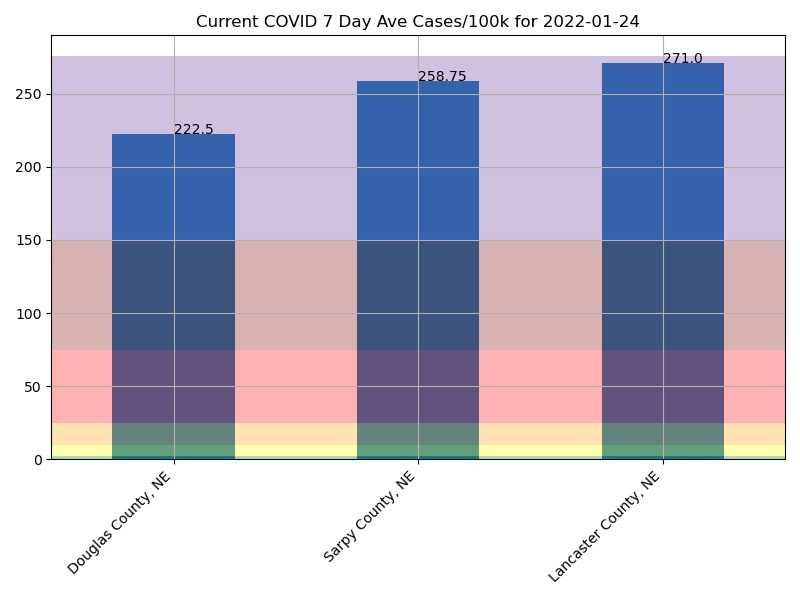

in set_graph_background_color_bands() max_value = 271.0


In [25]:
# Load data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import geopandas as gpd
import geoplot as gplt

#from google.colab import auth
#from oauth2client.client import GoogleCredentials

#import urllib2 as urllib

#print(pd.__version__)


# get list of series by using selected counties 
#def get_county_list(counties):

plot_days = 60
    
# get latest county values
current_county_values = dict()
counties_norm_cases = pd.DataFrame()
series_list = list() # global list of extracted county time series
    
#df = pd.read_csv('Risk Levels County Data.csv', parse_dates=True)

print("Loading Data from Brown Excel File...")
xlsx = pd.ExcelFile('../input/Risk Levels Downloadable Data.xlsx')
print('available sheets: ')
print(xlsx.sheet_names)
brown_excel_county_df = pd.read_excel(xlsx, "US County Risk Level")

print("Date: " +brown_excel_county_df.columns[-1]);
#
#print(brown_excel_county_df.head)
#print(brown_excel_county_df.dtypes)
#print(list(brown_excel_county_df))

# Get county list
#print("Get County List")
county_list = brown_excel_county_df['County'].unique()

#unique metric values
print("Metric Types")
print(brown_excel_county_df['Metric'].unique())

#print("Douglas Rows")

# Multiple Select object to select counties to plot
output0 = widgets.Output()
county_select = widgets.SelectMultiple(
    options=county_list.tolist(),
    name='US Counties',
    value=['Douglas County, NE', 'Sarpy County, NE', 'Lancaster County, NE'],
    rows=15,
    description='US Counties',
    disabled=False
)
display(county_select, output0)

# add plot button
output1 = widgets.Output()
plot_button = widgets.Button(description='Replot')
display(plot_button, output1)
def on_button_clicked(b):
    with output1:
        #global ave_cases_graph
        #global ave_cases_axes
        #ave_cases_graph.clear()
        #plt.clf()
        
        print("Selected Counties")
        print(county_select.value)
        
        
        get_latest_county_values(county_select.value)
        
        plot_current_case_values()
        
        #[l.remove() for l in ax.lines]
        #ave_cases_axes = extract_and_plot_time_series()
        #ave_cases_axes.redraw_in_frame()
        #print("Button clicked: " +str(plot_days))

plot_button.on_click(on_button_clicked)

def on_value_change(change):
    with output0:
        print("Selected Counties")
        print(county_select.value)
        print(change)

# Graph configuration
plt.rcParams['figure.figsize'] = [8, 6]

# extract individual county data - should be depricated
#douglas = brown_excel_county_df.loc[county_df['County'] == 'Douglas County, NE']
#sarpy = brown_excel_county_df.loc[county_df['County'] == 'Sarpy County, NE']
#lancaster = brown_excel_county_df.loc[county_df['County'] == 'Lancaster County, NE']

#print("iloc test: ")
#tmp_df = brown_excel_county_df.iloc[3350, :-1]
#print(tmp_df)

#county data offsets
# 0 - risk level color
# 1 - daily ave new cases
# 2 - daily norm ave new cases
# 3 - rank

%matplotlib notebook

# create axes for plots
current_cases_graph, current_values_axes = plt.subplots()


def get_county_norm_new_cases(brown_excel_county_df, name, num_days):
    #print(num_days)
    num_days_index = -num_days
    norm_cases_list = pd.Series(brown_excel_county_df.iloc[2,num_days_index:], name=name)
    norm_cases_df = pd.DataFrame(norm_cases_list.astype(np.float16))
    #print(type(norm_cases_list))
    #print(brown_excel_county_df.iloc[2,-2:-0])
    #print(brown_excel_county_df.iat[2, -1])
    #print("raw df: " +name)
    #print(brown_excel_county_df)

    return norm_cases_df

def get_county_new_cases_rank(brown_excel_county_df, name):
    new_cases_rank_list = pd.Series(brown_excel_county_df.iloc[3,-90:], name=name)
    new_cases_rank_df = pd.DataFrame(new_cases_rank_list.astype(np.float16))
    #print(type(new_cases_rank_df))
    #print(new_cases_rank_df)

    return new_cases_rank_df

# gets time series and latest value data from county DataFrame for a list of counties
# latest values are put in global current_county_values
# time series data is put in global counties_norm_cases
def get_latest_county_values(counties_list):
    #current_county_values
    global current_county_values
    #current_county_values.clear()
    global counties_norm_cases
    global series_list
    series_list.clear()
    
    appended_data = []
    appended_current_data = dict()
    
    for county in counties_list:
        county_full_series = brown_excel_county_df.loc[brown_excel_county_df['County'] == county]
        #print("county_full_series shape:")
        #print(county_full_series.shape)
        series_list.append(county_full_series)
        county_latest_value = county_full_series.iat[2, -1]
        #county_full_series = county_series.iat[2, -1]
        
        appended_current_data.update({county : county_latest_value});
        #print(county +" : " +str(county_latest_value))
        
        county_series_slice = get_county_norm_new_cases(county_full_series, county, plot_days)
        appended_data.append(county_series_slice)
    
    current_county_values = pd.Series(appended_current_data, 
                             dtype='float16')
    #counties_norm_cases = counties_norm_cases.iloc[0:0]
    counties_norm_cases = pd.concat(appended_data, axis=1) #series_list)

def set_graph_background_color_bands(graph_axes, max_value):
    print("in set_graph_background_color_bands() max_value = " +str(max_value))
    graph_axes.axhspan(0, 2, facecolor='green', alpha=0.3)
    graph_axes.axhspan(2, 10, facecolor='yellow', alpha=0.3)
    graph_axes.axhspan(10, 25, facecolor='orange', alpha=0.3)

    if(max_value > 150):
        graph_axes.axhspan(25, 75, facecolor='red', alpha=0.3)
        graph_axes.axhspan(75, 150, facecolor='maroon', alpha=0.3)
        graph_axes.axhspan(150, float(max_value)+5, facecolor='darkmagenta', alpha=0.5)
    elif(max_value > 75):
        graph_axes.axhspan(25, 75, facecolor='red', alpha=0.3)
        graph_axes.axhspan(75, float(max_value)+5, facecolor='maroon', alpha=0.3)
    else:
        graph_axes.axhspan(25, float(max_value)+5, facecolor='red', alpha=0.3)

def plot_current_case_values():
    global current_new_cases
    global current_values_axes
    
    current_values_axes.clear()
    
    current_date = brown_excel_county_df.columns[-1]

    #find max of current values to size graph appropriately
    cases_set_max = max(current_county_values) #douglas_current, sarpy_current, lancaster_current)
    #print("max; " +str(cases_set_max))

    #current_values_axes = current_new_cases.plot(kind="bar", ax=current_values_axes)
    current_values_axes = current_county_values.plot(kind="bar", ax=current_values_axes)
    plt.xticks(rotation=45, ha='right')

    # show values on bar graph
    for index, value in enumerate(current_county_values):
        current_values_axes.text(index, value,
             str(value))
    #print(value)

    current_values_axes.grid()
    
    current_values_axes.set_title("Current COVID 7 Day Ave Cases/100k for " +str(current_date))

    # add color bands for severity 
    set_graph_background_color_bands(current_values_axes, cases_set_max)
  
    plt.tight_layout()
    
    plt.show()

    
get_latest_county_values(county_select.value)

plot_current_case_values()

#print('Douglas Ave New Cases /100k = ' +douglas.iat[2, -1])
#print('Douglas Rank = ' +douglas.iat[3, -1])
#print('Douglas Ave/100k past 90 days')

# Extract and plot county new cases rank - not currently used
#douglas_rank_series = get_county_new_cases_rank(douglas, "Douglas")
#sarpy_rank_series = get_county_new_cases_rank(sarpy, "Sarpy")
#lancaster_rank_series = get_county_new_cases_rank(lancaster, "Lancaster")
#counties_cases_rank = pd.concat(
#    [douglas_rank_series, sarpy_rank_series, lancaster_rank_series], axis=1)
#print(counties_cases_rank.shape);
#counties_cases_rank.plot()

plt.show()



## County Average Daily New Cases / 100k

<IPython.core.display.Javascript object>


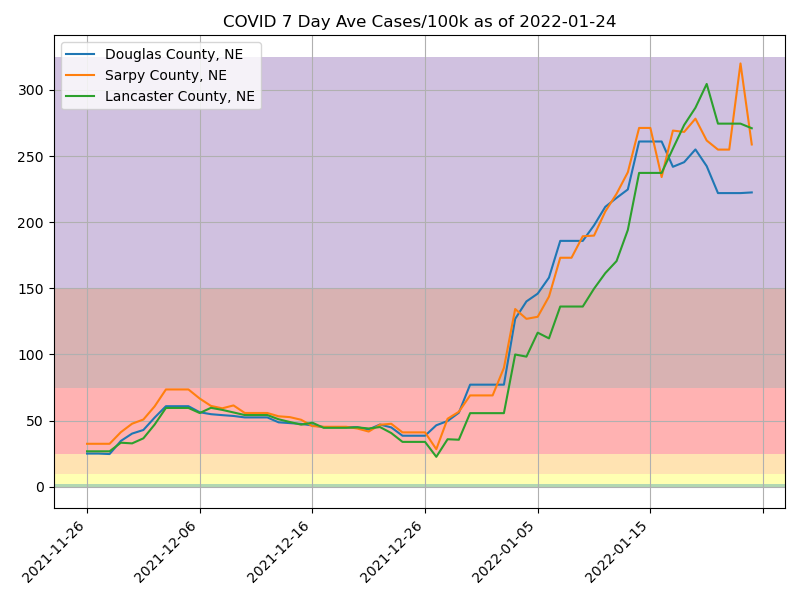

IntSlider(value=60, description='Days to Plot', max=269, min=30)

Output()

Button(description='Replot', style=ButtonStyle())

Output()

in set_graph_background_color_bands() max_value = 320.0


In [26]:
# Plot 7 day ave daily cases /100k


output = widgets.Output()


ave_cases_graph, ave_cases_axes = plt.subplots()

#plt.ion()

# set days to plot with IntSlider
max_days = len(brown_excel_county_df.columns) - 2
plt_range = widgets.IntSlider(description = 'Days to Plot', value = plot_days, min = 30, max = max_days);

display(plt_range, output)

def on_value_change(change):
    with output:
        global plot_days
        plot_days = change['new']
        #print(plot_days)

plt_range.observe(on_value_change, names='value')

# add plot button
output2 = widgets.Output()
plot_button = widgets.Button(description='Replot')
display(plot_button, output2)
def on_button_clicked(b):
    with output2:
        global ave_cases_graph
        global ave_cases_axes
        #ave_cases_graph.clear()
        #plt.clf()
        
        print("Selected Counties")
        print(county_select.value)
        
        
        get_latest_county_values(county_select.value)
        
        #plot_current_case_values()
        
        #[l.remove() for l in ax.lines]
        ave_cases_axes = extract_and_plot_time_series()
        #ave_cases_axes.redraw_in_frame()
        print("Button clicked: " +str(plot_days))

plot_button.on_click(on_button_clicked)

# extract and plot daily ave new cases / 100k
def extract_and_plot_time_series():
    global ave_cases_graph
    global ave_cases_axes
    global counties_norm_cases
    
    # need to move these series extractions to get_latest_county_values()
    #douglas_series = get_county_norm_new_cases(douglas, "Douglas", plot_days)
    #sarpy_series = get_county_norm_new_cases(sarpy, "Sarpy", plot_days)
    #lancaster_series = get_county_norm_new_cases(lancaster, "Lancaster", plot_days)
    #counties_norm_cases = pd.concat(
               #[douglas_series, sarpy_series, lancaster_series], axis=1)
        
    current_date = brown_excel_county_df.columns[-1]

    max_value = counties_norm_cases.max().max()
    #print("Max value: ")
    #print(max_value)
    #print("counties_norm_cases - shape")
    #print(counties_norm_cases.shape);
    #print(normCasesList.dtypes);
    #print("combined structure: " +counties_norm_cases.shape);
    ave_cases_axes.clear()
    ave_cases_axes = counties_norm_cases.plot(ax=ave_cases_axes)
    #counties_norm_cases.plot()
    plt.xticks(rotation=45, ha='right')
    
    ave_cases_axes.set_title("COVID 7 Day Ave Cases/100k as of " +str(current_date))
    
    set_graph_background_color_bands(ave_cases_axes, max_value)
    
    ave_cases_axes.grid()
    plt.tight_layout()
    #plt.show()
    #print("ave_cases_graph: ")
    #print(type(ave_cases_graph))

    #counties_norm_cases.style

get_latest_county_values(county_select.value)
    
extract_and_plot_time_series()

## CSSE Online County Data

Loading CSSE County CSV data...
(3342, 745)
Loading US population data...
(3094, 6)


SelectMultiple(description='US Counties', index=(1745, 1795, 1772, 1815), options=('Autauga, Alabama, US', 'Ba…

Output()

Button(description='Replot', style=ButtonStyle())

Output()

<IPython.core.display.Javascript object>


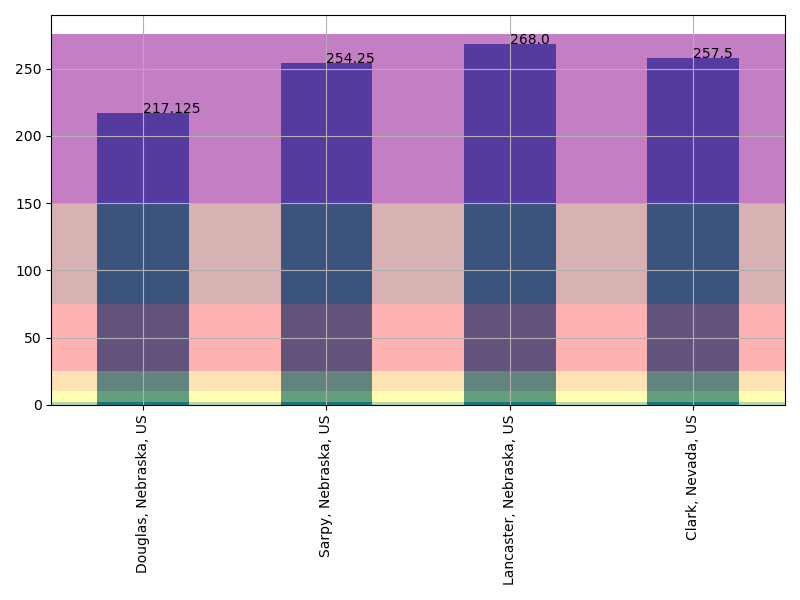

<IPython.core.display.Javascript object>


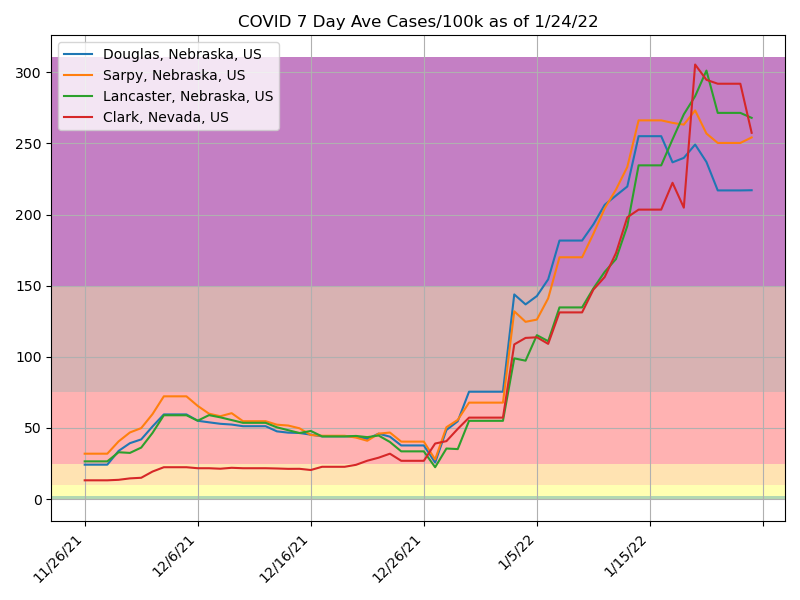

in get_latest_csse_county_values()
County: Douglas, Nebraska, US
Douglas:Nebraska
calculating normalized rolling average
County: Sarpy, Nebraska, US
Sarpy:Nebraska
calculating normalized rolling average
County: Lancaster, Nebraska, US
Lancaster:Nebraska
calculating normalized rolling average
County: Clark, Nevada, US
Clark:Nevada
calculating normalized rolling average
Douglas, Nebraska, US      217.125
Sarpy, Nebraska, US        254.250
Lancaster, Nebraska, US    268.000
Clark, Nevada, US          257.500
dtype: float16
calling - plot_current_csse_case_values
in plot_current_csse_case_values()
in set_graph_background_color_bands() max_value = 271.0
In csse_extract_and_plot_time_series()
in set_graph_background_color_bands() max_value = 305.5


<IPython.core.display.Javascript object>


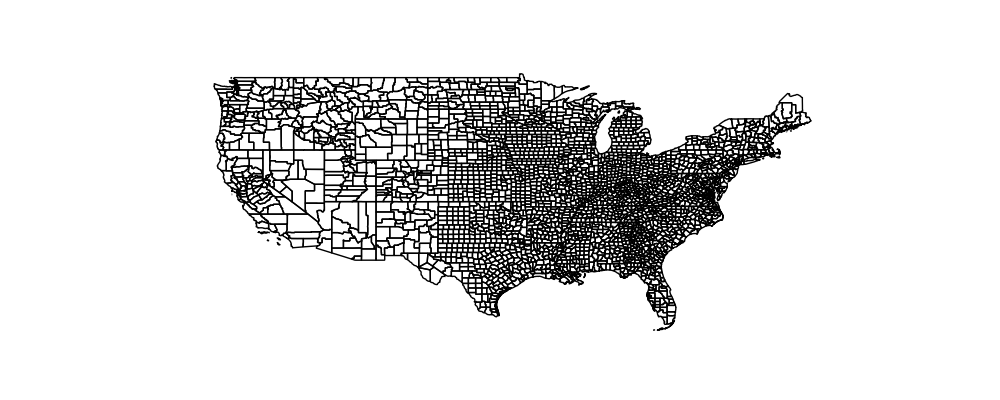

C:\Users\phild\anaconda3\envs\geo_env\lib\site-packages\geoplot\geoplot.py:903: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


In [30]:
#Load online county csv data
csse_us_county_cases_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv';

county_pop_url = 'https://raw.githubusercontent.com/balsama/us_counties_data/main/data/counties.csv'

print("Loading CSSE County CSV data...")

csse_plot_days = 60

csse_county_df = pd.read_csv(csse_us_county_cases_URL, parse_dates=True)
print(csse_county_df.shape)
#print(csse_county_df.dtypes)
#print(csse_county_df.head)

print("Loading US population data...")
county_pop_df = pd.read_csv(county_pop_url, parse_dates=True)
print(county_pop_df.shape)
#print(county_pop_df.dtypes)
#print(county_pop_df.head)

# declare global variables
# get latest csse county values
csse_current_county_values = dict()
csse_counties_norm_cases_df = pd.DataFrame()
csse_series_list = list() # global list of extracted county time series

# get all county values for searches
csse_county_list = csse_county_df['Combined_Key'].unique()

# populate multiple select widget with counties
output_csse_county = widgets.Output()
csse_county_select = widgets.SelectMultiple(
    options=csse_county_list.tolist(),
    name='US Counties',
    value=['Douglas, Nebraska, US', 'Sarpy, Nebraska, US', 'Lancaster, Nebraska, US', 'Clark, Nevada, US'],
    rows=15,
    description='US Counties',
    disabled=False
)
display(csse_county_select, output_csse_county)

# add plot button
output_csse_button = widgets.Output()
csse_plot_button = widgets.Button(description='Replot')
display(csse_plot_button, output_csse_button)
def csse_on_button_clicked(b):
    with output_csse_button:
        #global ave_cases_graph
        #global ave_cases_axes
        #ave_cases_graph.clear()
        #plt.clf()
        
        print("Selected Counties")
        print(csse_county_select.value)
        get_latest_csse_county_values(csse_county_select.value)

        print("calling - plot_current_csse_case_values")
        csse_plot_current_case_values()

        csse_extract_and_plot_time_series()
        
        #[l.remove() for l in ax.lines]
        #ave_cases_axes = extract_and_plot_time_series()
        #ave_cases_axes.redraw_in_frame()
        #print("Button clicked: " +str(plot_days))

csse_plot_button.on_click(csse_on_button_clicked)


# create axes for plots
csse_current_cases_graph, csse_current_values_axes = plt.subplots()
csse_ave_cases_graph, csse_ave_cases_axes = plt.subplots()

#def csse_get_county_norm_new_cases(brown_excel_county_df, name, num_days):
#    #print(num_days)
#    num_days_index = -num_days
#    norm_cases_list = pd.Series(brown_excel_county_df.iloc[2,num_days_index:], name=name)
#    norm_cases_df = pd.DataFrame(norm_cases_list.astype(np.float16))
#    #print(type(norm_cases_list))
#    #print(brown_excel_county_df.iloc[2,-2:-0])
#    #print(brown_excel_county_df.iat[2, -1])
#    #print("raw df: " +name)
#    #print(brown_excel_county_df)
#
#    return norm_cases_df

# normalize value to local cases per 100k
def pop_normalize(value, pop):
    return value * 100000/pop
    
# gets time series and latest value data from county DataFrame for a list of counties
# latest values are put in global current_county_values
# time series data is put in global counties_norm_cases
def get_latest_csse_county_values(counties_list):
    print("in get_latest_csse_county_values()")
    #current_county_values
    global csse_current_county_values
    #current_county_values.clear()
    global csse_counties_norm_cases_df
    global csse_series_list
    csse_series_list.clear()
    
    appended_data = []
    appended_current_data = dict()
    
    for county in counties_list:
        print("County: " +str(county))
        
        # get county population
        county_loc_terms = county.split(', ')
        print(county_loc_terms[0] +':' +county_loc_terms[1])
        #county_pop = county_pop_df.query('County==county_loc_terms[0] & State==county_loc_terms[1] ')
        
        # get all counts for selected county
        county_pop_series = county_pop_df[
            (county_pop_df.County==county_loc_terms[0] +' County') & (county_pop_df.State==county_loc_terms[1])]
            #(county_pop_df['County']==county_loc_terms[0]) & (county_pop_df['State']==county_loc_terms[1])]
        county_pop = county_pop_series.iat[0,3]

        # extract just the daily case counts from selected row
        county_counts_only_df = csse_county_df.loc[csse_county_df['Combined_Key'] == county].iloc[0, 11:]
        #print(county_counts_only_df)
        
        # get rolling average of daily difference in cases
        print("calculating normalized rolling average")
        #county_full_series = county_counts_only_df.diff().shift().rolling(7).mean().apply(pop_normalize, args=(county_pop,))
        county_full_series = county_counts_only_df.diff().rolling(7).mean().apply(pop_normalize, args=(county_pop,))
        #print(type(county_full_series))
        #print(county_full_series)
        
        # extract selected number of days for plot
        num_days_index = -csse_plot_days
        norm_cases_list = pd.Series(county_full_series.iloc[num_days_index:], name=county)
        norm_cases_df = pd.DataFrame(norm_cases_list.astype(np.float16))
        #print(county_full_series.shape)
        #print(county_full_series)
        series_list.append(county_full_series)
        
        
        county_latest_value = county_full_series.iat[-1]
        
        appended_current_data.update({county : county_latest_value});
        #print(county +" : " +str(county_latest_value))
        
        #county_series_slice = get_county_norm_new_cases(county_full_series, county, plot_days)
        appended_data.append(norm_cases_df)
    
    csse_current_county_values = pd.Series(appended_current_data, 
                             dtype='float16')
    print(csse_current_county_values)
    #counties_norm_cases = counties_norm_cases.iloc[0:0]
    csse_counties_norm_cases_df = pd.concat(appended_data, axis=1) #series_list)
    #print('csse_counties_norm_cases_df set type:' +str(type(csse_counties_norm_cases_df)))
    #print(csse_counties_norm_cases_df)


def set_graph_background_color_bands(graph_axes, max_value):
    print("in set_graph_background_color_bands() max_value = " +str(max_value))
    graph_axes.axhspan(0, 2, facecolor='green', alpha=0.3)
    graph_axes.axhspan(2, 10, facecolor='yellow', alpha=0.3)
    graph_axes.axhspan(10, 25, facecolor='orange', alpha=0.3)

    if(max_value > 150):
        graph_axes.axhspan(25, 75, facecolor='red', alpha=0.3)
        graph_axes.axhspan(75, 150, facecolor='maroon', alpha=0.3)
        graph_axes.axhspan(150, float(max_value)+5, facecolor='darkmagenta', alpha=0.5)
    elif(max_value > 75):
        graph_axes.axhspan(25, 75, facecolor='red', alpha=0.3)
        graph_axes.axhspan(75, float(max_value)+5, facecolor='maroon', alpha=0.3)
    else:
        graph_axes.axhspan(25, float(max_value)+5, facecolor='red', alpha=0.3)
    
def csse_plot_current_case_values():
    print("in plot_current_csse_case_values()")
    global csse_current_county_values
    global csse_current_new_cases
    global csse_current_values_axes
    
    csse_current_values_axes.clear()
    
    current_date = csse_county_df.columns[-1]

    #find max of current values to size graph appropriately
    cases_set_max = max(current_county_values) #douglas_current, sarpy_current, lancaster_current)
    #print("max; " +str(cases_set_max))
    
    #print(csse_current_county_values)

    #current_values_axes = current_new_cases.plot(kind="bar", ax=current_values_axes)
    csse_current_values_axes = csse_current_county_values.plot(kind="bar", ax=csse_current_values_axes)
  
    # show values on bar graph
    for index, value in enumerate(csse_current_county_values):
        csse_current_values_axes.text(index, value,
             str(value))
    #print(value)
    
    csse_current_values_axes.grid()

    # add color bands for severity 
    set_graph_background_color_bands(csse_current_values_axes, cases_set_max)
    
    
    csse_current_cases_graph.tight_layout()
    
    plt.xticks(rotation=45, ha='right')
    #csse_current_values_axes.set_xticklabels(csse_current_values_axes.get_xticks(), rotation = 45)

   
    plt.show()
    
# extract and plot daily ave new cases / 100k
def csse_extract_and_plot_time_series():
    print('In csse_extract_and_plot_time_series()')
    global csse_ave_cases_graph
    global csse_ave_cases_axes
    global csse_counties_norm_cases_df
    
    #print("csse_counties_norm_cases_df type:" +str(type(csse_counties_norm_cases_df)))
    #print(csse_counties_norm_cases_df)
    
    current_date = csse_county_df.columns[-1]
          
    max_value = csse_counties_norm_cases_df.max().max()
    #print("Max value: ")
    #print(max_value)
    
    csse_ave_cases_axes.clear()
    csse_ave_cases_axes = csse_counties_norm_cases_df.plot(ax=csse_ave_cases_axes)
    
    csse_ave_cases_axes.set_title("COVID 7 Day Ave Cases/100k as of " +str(current_date))
    
    set_graph_background_color_bands(csse_ave_cases_axes, max_value)
    
    csse_ave_cases_axes.grid()
    
    #csse_ave_cases_axes.set_xticklabels(csse_ave_cases_axes.get_xticks(), rotation = 45)
    plt.xticks(rotation=45, ha='right')
    csse_ave_cases_graph.tight_layout()
    #plt.show()
    #print("ave_cases_graph: ")
    #print(type(ave_cases_graph))

    #counties_norm_cases.style
    
    
def build_chloro_map():
    # Load the json file with county coordinates
    geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

    # Make sure the "id" column is an integer
    geoData.id = geoData.id.astype(str).astype(int)

    # Remove Alaska, Hawaii and Puerto Rico.
    stateToRemove = ['02', '15', '72']
    geoData = geoData[~geoData.STATE.isin(stateToRemove)]

    # Basic plot with just county outlines
    gplt.polyplot(geoData, figsize=(10, 4));
    
get_latest_csse_county_values(csse_county_select.value)

print("calling - plot_current_csse_case_values")
csse_plot_current_case_values()

csse_extract_and_plot_time_series()

build_chloro_map()

In [28]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %conda  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python 